# Time series

Find trend, seasonality, outliners and stationarize

In [2]:
# imports libraries
import pandas as pd
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
import numpy as np
import scipy.stats as st



In [22]:
# Selects data and creates a dataframe
df = pd.read_csv('Data_timeSeries.csv')
df['Period'] = pd.to_datetime(df['Period'], format="%Y%m")
df = df.set_index('Period')
df = df.resample('1M').sum()



Period for upper bound outliners is:
303 days 00:00:00

Period for lower bound outliners is:
641 days 00:00:00
2495 days 00:00:00

Trend of time series is growing and chosen point is in (of) boundaries.


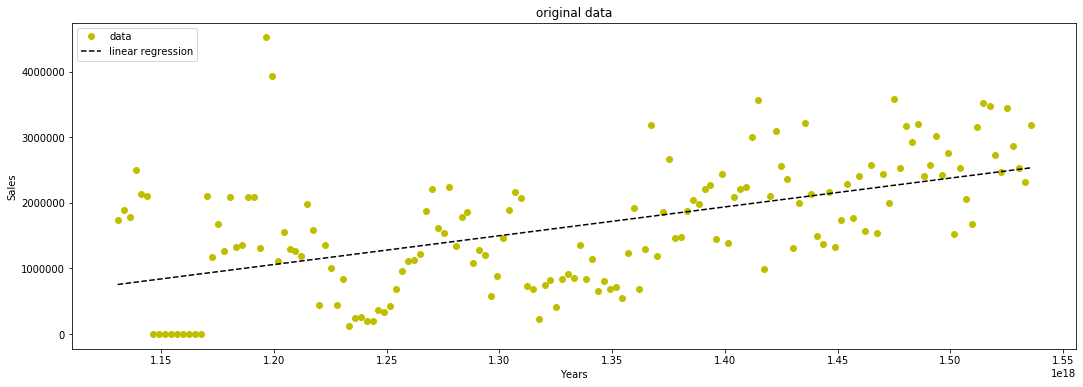

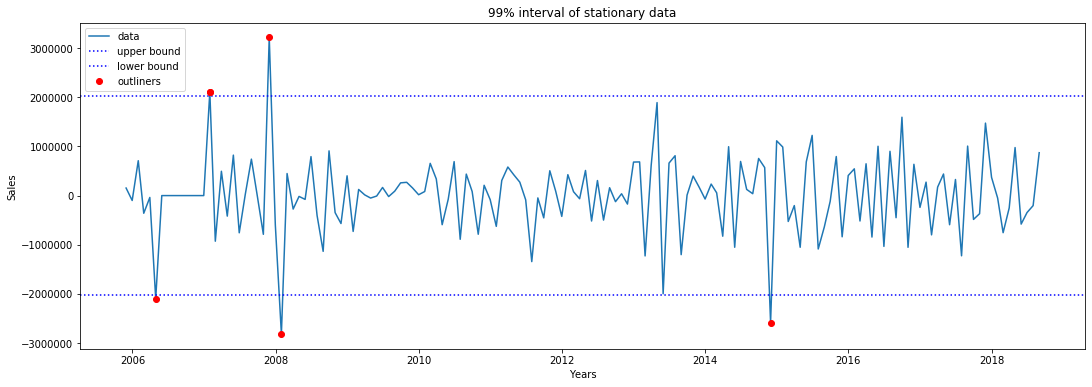

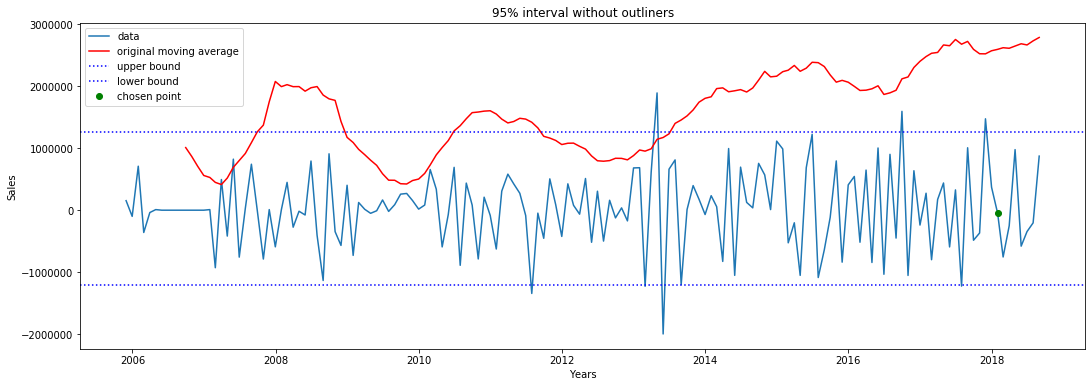

In [20]:
# Runs it all
main_function(df, -8)

In [24]:
# Find outliners in 99% interval, plots them and replace them for mean of the series


def outliners(df):
    name = df.columns[0]
    outline_points_up = []
    outline_points_down = []
    
    # find boundaries
    d, h = interval(df, 0.99)
    # calculate mean
    mean = np.mean(df[name])
    
    # plot data
    pyplot.figure(figsize=(18,6))
    pyplot.plot(df, label='data')
    pyplot.axhline(h, c='blue', ls=':', label='upper bound')
    pyplot.axhline(d, c='blue', ls=':', label='lower bound')
    
    # find, save and replace outliners
    for i in range(len(df[name])):
        point = df.iloc[i]
        
        if point[name] > h:
            outline_points_up.append((point[name], point.name))
            df[name].iloc[i] = mean
            
        elif point[name] < d:
            outline_points_down.append((point[name], point.name))
            df[name].iloc[i] = mean
                    
    # plot outliners        
    outline = outline_points_up + outline_points_down    
    pyplot.plot(outline[0][1], outline[0][0], 'ro', label='outliners')
    
    for i in outline:
            pyplot.plot(i[1], i[0], 'ro')
    
    pyplot.legend(loc='upper left')       
    pyplot.xlabel('Years')
    pyplot.ylabel('Sales')
    pyplot.title('99% interval of stationary data')

    # return an adjusted time series and lists of upper and lower outliners       
    return (df, outline_points_up, outline_points_down)        

In [15]:
# Calculates periods between list of points
def calc_period(outliners):
    diff = []
    for i in range(1,len(outliners)):
        diff.append(outliners[i][1]-outliners[i-1][1])
# Return time difference between points        
    return (diff)

In [16]:
# Main function, needs dataframe and order of point we are interested in


def main_function(df, point):

    name = df.columns[0]
    
    # Final outcome
    end = []
    
    # Checks if series is stationary
    result = adfuller_test(df)
    # Calculates moving average of original data
    moving_average = df.rolling(12).mean()
    
    # If series is not stationary it finds trend and tries to make it stationary
    outcome = 'stationary'
    if result > 0.05:
        trend = get_trend()
        if trend < 0:
            outcome = 'falling' 
        else:
            outcome = 'growing' 
        df = make_stationary(df)
    
    # Saves trend in end 
    end.append(outcome)    

    # Saves coordinates of chosen point 
    last = (df[name].iloc[point], df.iloc[point].name)

    # Finds and replaces outliners 
    df, outline_up, outline_down = outliners(df)
    seasonality_up = calc_period(outline_up)
    seasonality_down = calc_period(outline_down)
    
    # Finds 95% interval
    d,h = interval(df, 0.95)
    
    # Plot it all
    pyplot.figure(figsize=(18,6))
    pyplot.plot(df, label='data')
    pyplot.plot(moving_average, 'r', label='original moving average')
    pyplot.axhline(h, c='blue', ls=':', label='upper bound')
    pyplot.axhline(d, c='blue', ls=':', label='lower bound')   
    pyplot.xlabel('Years')
    pyplot.ylabel('Sales')
    pyplot.title('95% interval without outliners')         
    pyplot.plot(last[1], last[0], 'ro', c='green', label='chosen point')        
    pyplot.legend(loc='upper left')    
    
    # Checks if chosen point is within boundaries
    if d <= last[0] <= h:
        end.append('in')
    else:
        end.append('out')

    # Prints final outcomes    
    print("Period for upper bound outliners is:", *seasonality_up, sep='\n')
    print('\n'"Period for lower bound outliners is:", *seasonality_down, sep='\n')
    print('\n'"Trend of time series is", end[0], "and chosen point is", end[1], "(of) boundaries.")


In [17]:
# Checks if series is stationary
def adfuller_test(df):
    name = df.columns[0]
    result = adfuller(df[name])
    # Return p-value
    return result[1]  

In [18]:
# Finds trend in series
def get_trend():
    name = df.columns[0]
    
    # Gets list of periods (as int) and sales(y)
    x = list(map(int, df.index.values))
    y = df[name].values

    pyplot.figure(figsize=(18, 6))
    # Fit line through points
    fit = np.polyfit(x, y, 1)
    # Get the predicted line
    fit_fn = np.poly1d(fit) 

    # Plots it all    
    pyplot.plot(x,y,  'yo', label="data")
    pyplot.plot(x, fit_fn(x), '--k', label="linear regression")
    pyplot.legend(loc='upper left')       
    pyplot.xlabel('Years')
    pyplot.ylabel('Sales')
    pyplot.title('original data')
    
    # Returns coefficient of fitted line (indicates growing or falling)
    return fit[0]

In [19]:
# Calculates interval of confidence
def interval(df, prct):
    name = df.columns[0]
    mean = np.mean(df[name])
    sigma = np.std(df[name])

    conf_int = st.norm.interval(prct, loc=mean, scale=sigma)
    d = conf_int[0]
    h = conf_int[1]
    # Returns upper and lower line of interval
    return (d, h)

In [20]:
# Tries to make series stationary by first difference
def make_stationary(data):
    result = adfuller_test(data.diff(1).dropna())
    if result < 0.05:
        # Returns stationary series
        return data.diff(1)
    else:
        print('cant make stationary')
        # Or return original series if first difference did not work
        return data